<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/ConcreteGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Concrete dataset

In [117]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/concrete.ipynb" # Run the Concrete notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in

# Prepare The Data

In [119]:
concrete_data = df_Concrete # df_Concrete is defined in ../datasets/concrete.ipynb
# Concrete compressive strength(last feature) is the regression problem
x_concrete, y_concrete = concrete_data.iloc[:, :-1].to_numpy() , concrete_data.iloc[:, -1].to_numpy()

x_train_concrete, x_test_concrete, y_train_concrete, y_test_concrete = train_test_split(x_concrete,
                                                                                        y_concrete,
                                                                                        test_size=0.2,
                                                                                        random_state=666)
# Transform into tensors
x_train_concrete, x_test_concrete, y_train_concrete, y_test_concrete = (
torch.from_numpy(x_train_concrete).float(), torch.from_numpy(x_test_concrete).float(),
torch.from_numpy(y_train_concrete).float(), torch.from_numpy(y_test_concrete).float())

# Standardized data
scaler = StandardScaler()
x_train_concrete_standardized = torch.from_numpy(scaler.fit_transform(x_train_concrete)).float()
# Use the same scaler that was used on training data
x_test_concrete_standardized = torch.from_numpy(scaler.transform(x_test_concrete)).float()

if torch.cuda.is_available():
    x_train_concrete, y_train_concrete, x_test_concrete, y_test_concrete, x_train_concrete_standardized, x_test_concrete_standardized = (
    x_train_concrete.cuda(), y_train_concrete.cuda(), x_test_concrete.cuda(), y_test_concrete.cuda(),
    x_train_concrete_standardized.cuda(), x_test_concrete_standardized.cuda())

# Train data into batches
#train_dataset_concrete = TensorDataset(x_train_concrete, y_train_concrete)
#train_loader_concrete = DataLoader(train_dataset_concrete, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_concrete = TensorDataset(x_test_concrete, y_test_concrete)
#test_loader_concrete = DataLoader(test_dataset_concrete, batch_size=500, shuffle=False)

# Standardized batches
# Train data into batches
#train_dataset_concrete_standardized = TensorDataset(x_train_concrete_standardized, y_train_concrete)
#train_loader_concrete_standardized = DataLoader(train_dataset_concrete_standardized, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_concrete_standardized = TensorDataset(x_test_concrete_standardized, y_test_concrete)
#test_loader_concrete_standardized = DataLoader(test_dataset_concrete_standardized, batch_size=500, shuffle=False)

# Define the KISS-GP Model

In [120]:
KISSGP_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_concrete = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_concrete = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_concrete = KISSGP_NDim(x_train_concrete,
                                 y_train_concrete,
                                 KISSGP_likelihood_concrete,
                                 KISSGP_mean_concrete,
                                 KISSGP_kernel_concrete) # KISSGP defined in utils/Models.ipynb
KISSGP_model_concrete = KISSGP_model_concrete.to(device) # Move model to device.

# One with standardized features
KISSGP_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_concrete_standardized = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_concrete_standardized = KISSGP_NDim(x_train_concrete_standardized,
                                              y_train_concrete,
                                              KISSGP_likelihood_concrete_standardized,
                                              KISSGP_mean_concrete_standardized,
                                              KISSGP_kernel_concrete_standardized) # KISSGP defined in utils/Models.ipynb
KISSGP_model_concrete_standardized = KISSGP_model_concrete_standardized.to(device) # Move model to device.

# Train and Evaluate the KISS-GP Model

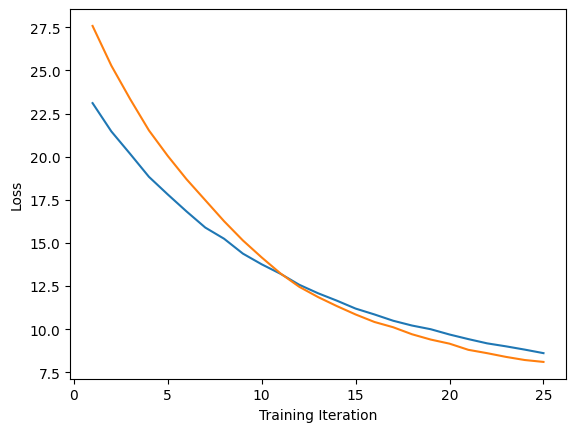

In [121]:
train_time_KISSGP_concrete = train(KISSGP_model_concrete,
                          KISSGP_likelihood_concrete,
                          x_train_concrete,
                          y_train_concrete,
                          training_iter= 25) # train is defined in utils/functions.ipynb
# Standardized version
train_time_KISSGP_concrete_standardized = train(KISSGP_model_concrete_standardized,
                                       KISSGP_likelihood_concrete_standardized,
                                       x_train_concrete_standardized,
                                       y_train_concrete,
                                       training_iter= 25) # train is defined in utils/functions.ipynb

In [122]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_concrete = predict(KISSGP_model_concrete, KISSGP_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_concrete, NLPD_KISSGP_concrete, PICP_KISSGP_concrete, MPIW_KISSGP_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_KISSGP_concrete.mean,
      predictions_KISSGP_concrete.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_KISSGP_concrete_standardized = predict(KISSGP_model_concrete_standardized, KISSGP_likelihood_concrete_standardized,
                                                  x_test_concrete_standardized) # predict is defined in utils/functions.ipynb

  RMSE_KISSGP_concrete_standardized, NLPD_KISSGP_concrete_standardized, PICP_KISSGP_concrete_standardized, MPIW_KISSGP_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_KISSGP_concrete_standardized.mean,
      predictions_KISSGP_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_concrete)
  print("NLPD KISS-GP: ",NLPD_KISSGP_concrete)
  print("PICP KISS-GP: ",PICP_KISSGP_concrete)
  print("MPIW KISS-GP: ",MPIW_KISSGP_concrete)
  print("Time KISS-GP: ", train_time_KISSGP_concrete)

  print("RMSE KISS-GP Standardized: ",RMSE_KISSGP_concrete_standardized)
  print("NLPD KISS-GP Standardized: ",NLPD_KISSGP_concrete_standardized)
  print("PICP KISS-GP Standardized: ",PICP_KISSGP_concrete_standardized)
  print("MPIW KISS-GP Standardized: ",MPIW_KISSGP_concrete_standardized)
  print("Time KISS-GP Standardized: ", train_time_KISSGP_concrete_standardized)

RMSE KISS-GP:  7.298903
NLPD KISS-GP:  tensor(9.4190)
PICP KISS-GP:  0.4029126213592233
MPIW KISS-GP:  7.470776
Time KISS-GP:  4.5991833209991455
RMSE KISS-GP Standardized:  5.0361915
NLPD KISS-GP Standardized:  tensor(4.9882)
PICP KISS-GP Standardized:  0.5825242718446602
MPIW KISS-GP Standardized:  7.561472
Time KISS-GP Standardized:  9.60771894454956


# Variational Distribution Model

In [123]:
variational_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_concrete = gpytorch.means.ConstantMean()
variational_kernel_concrete = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_concrete/2))
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete.size(0))
# Select N random rows
inducing_points = x_train_concrete[indices][:n_inducing_points]
variational_model_concrete = variationalGP(variational_likelihood_concrete,
                                        variational_mean_concrete,
                                        variational_kernel_concrete,
                                        inducing_points) # InducingGP defined in utils/models.ipynb
variational_model_concrete = variational_model_concrete.to(device) # Move model to device, defined in utils/models.ipynb

# Standardized version
variational_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_concrete_standardized = gpytorch.means.ConstantMean()
variational_kernel_concrete_standardized = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_concrete_standardized/2))
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_concrete_standardized[indices][:n_inducing_points]
variational_model_concrete_standardized = variationalGP(variational_likelihood_concrete_standardized,
                                               variational_mean_concrete_standardized,
                                               variational_kernel_concrete_standardized,
                                               inducing_points_standardized) # InducingGP defined in utils/models.ipynb
variational_model_concrete_standardized = variational_model_concrete_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train and Evaluate Variational Model

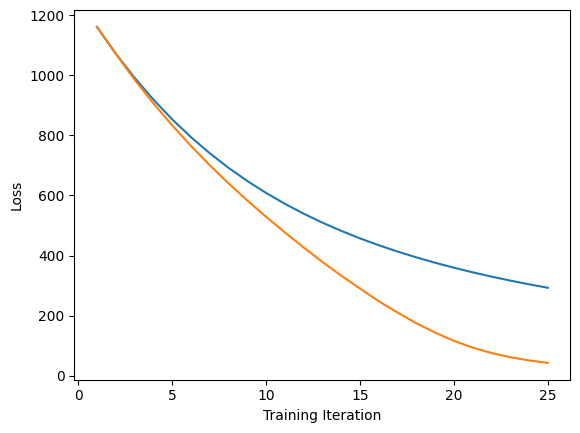

In [124]:
# Use train_loader_concrete
train_time_variational_concrete = train_ELBO(variational_model_concrete,
                                 variational_likelihood_concrete,
                                 x_train_concrete,
                                 y_train_concrete,
                                 training_iter= 25) # train is defined in utils/functions.ipynb

# Standardized version, train_loader_concrete_standardized
train_time_variational_concrete_standardized = train_ELBO(variational_model_concrete_standardized,
                                              variational_likelihood_concrete_standardized,
                                              x_train_concrete_standardized,
                                              y_train_concrete,
                                              training_iter= 25) # train is defined in utils/functions.ipynb

In [125]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_concrete = predict(variational_model_concrete, variational_likelihood_concrete, x_test_concrete)

  RMSE_variational_concrete, NLPD_variational_concrete, PICP_variational_concrete, MPIW_variational_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_variational_concrete.mean,
      predictions_variational_concrete.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_concrete)
  print("NLPD variational Model: ",NLPD_variational_concrete)
  print("PICP variational Model: ",PICP_variational_concrete)
  print("MPIW variational Model: ",MPIW_variational_concrete)
  print("Time variational Model: ", train_time_variational_concrete)

  # Standardized version
  predictions_variational_concrete_standardized = predict(variational_model_concrete_standardized,
                                       variational_likelihood_concrete_standardized,
                                       x_test_concrete_standardized)

  RMSE_variational_concrete_standardized, NLPD_variational_concrete_standardized, PICP_variational_concrete_standardized, MPIW_variational_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_variational_concrete_standardized.mean,
      predictions_variational_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model Standardized: ",RMSE_variational_concrete_standardized)
  print("NLPD variational Model Standardized: ",NLPD_variational_concrete_standardized)
  print("PICP variational Model Standardized: ",PICP_variational_concrete_standardized)
  print("MPIW variational Model Standardized: ",MPIW_variational_concrete_standardized)
  print("Time variational Model Standardized: ", train_time_variational_concrete_standardized)

RMSE variational Model:  33.88164865546585
NLPD variational Model:  tensor(146.5432, dtype=torch.float64)
PICP variational Model:  0.019417475728155338
MPIW variational Model:  7.95099560612532
Time variational Model:  32.60121393203735
RMSE variational Model Standardized:  9.790443505568389
NLPD variational Model Standardized:  tensor(15.6419, dtype=torch.float64)
PICP variational Model Standardized:  0.2621359223300971
MPIW variational Model Standardized:  7.041892141870726
Time variational Model Standardized:  16.271397829055786


# Inducing Points Model

In [126]:
inducing_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_concrete = gpytorch.means.ConstantMean() # Mean
inducing_kernel_concrete = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete.size(0))
# Select N random rows
inducing_points_amount = int(len(x_train_concrete/2)) # Around half of the points
inducing_points = x_train_concrete[indices][:inducing_points_amount].double()
inducing_model_concrete = inducingGP(x_train_concrete.double(),
                                 y_train_concrete.double(),
                                 inducing_likelihood_concrete,
                                 inducing_mean_concrete,
                                 inducing_kernel_concrete,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

inducing_model_concrete = inducing_model_concrete.to(device) # Move model to device.

# One with standardized features
inducing_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
inducing_kernel_concrete_standardized = gpytorch.kernels.RBFKernel() # Kernel
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_concrete_standardized[indices][:inducing_points_amount]
inducing_model_concrete_standardized = inducingGP(x_train_concrete_standardized,
                                              y_train_concrete,
                                              inducing_likelihood_concrete_standardized,
                                              inducing_mean_concrete_standardized,
                                              inducing_kernel_concrete_standardized,
                                              inducing_points_standardized) # inducingGP defined in utils/Models.ipynb

inducing_model_concrete_standardized = inducing_model_concrete_standardized.to(device) # Move model to device.

# Train and Evaluate Inducing Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


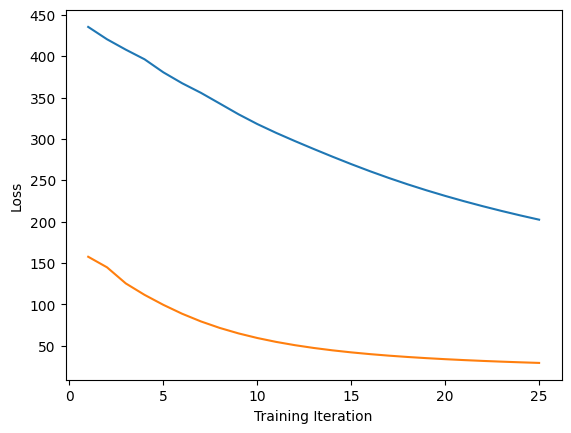

In [127]:
train_time_inducing_concrete = train(inducing_model_concrete,
                          inducing_likelihood_concrete,
                          x_train_concrete.double(),
                          y_train_concrete.double(),
                          training_iter= 25) # train is defined in utils/functions.ipynb
# Standardized version
train_time_inducing_concrete_standardized = train(inducing_model_concrete_standardized,
                                       inducing_likelihood_concrete_standardized,
                                       x_train_concrete_standardized,
                                       y_train_concrete,
                                       training_iter= 25) # train is defined in utils/functions.ipynb

In [128]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_concrete = predict(inducing_model_concrete, inducing_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_inducing_concrete, NLPD_inducing_concrete, PICP_inducing_concrete, MPIW_inducing_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_inducing_concrete.mean,
      predictions_inducing_concrete.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_inducing_concrete_standardized = predict(inducing_model_concrete_standardized, inducing_likelihood_concrete_standardized,
                                                  x_test_concrete_standardized) # predict is defined in utils/functions.ipynb

  RMSE_inducing_concrete_standardized, NLPD_inducing_concrete_standardized, PICP_inducing_concrete_standardized, MPIW_inducing_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_inducing_concrete_standardized.mean,
      predictions_inducing_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE inducing: ",RMSE_inducing_concrete)
  print("NLPD inducing: ",NLPD_inducing_concrete)
  print("PICP inducing: ",PICP_inducing_concrete)
  print("MPIW inducing: ",MPIW_inducing_concrete)
  print("Time inducing: ", train_time_inducing_concrete)

  print("RMSE inducing Standardized: ",RMSE_inducing_concrete_standardized)
  print("NLPD inducing Standardized: ",NLPD_inducing_concrete_standardized)
  print("PICP inducing Standardized: ",PICP_inducing_concrete_standardized)
  print("MPIW inducing Standardized: ",MPIW_inducing_concrete_standardized)
  print("Time inducing Standardized: ", train_time_inducing_concrete_standardized)

RMSE inducing:  31.09144090915119
NLPD inducing:  tensor(145.5584, dtype=torch.float64)
PICP inducing:  0.009708737864077669
MPIW inducing:  7.15313476038923
Time inducing:  20.95111894607544
RMSE inducing Standardized:  7.2114563
NLPD inducing Standardized:  tensor(12.2687)
PICP inducing Standardized:  0.3300970873786408
MPIW inducing Standardized:  5.948218
Time inducing Standardized:  6.807388067245483


# Exact Gaussian Process Model

In [129]:
exact_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_concrete = gpytorch.means.ConstantMean() # Mean
exact_kernel_concrete = gpytorch.kernels.MaternKernel() # Kernel
exact_model_concrete = exactGP(x_train_concrete,
                             y_train_concrete,
                             exact_likelihood_concrete,
                             exact_mean_concrete,
                             exact_kernel_concrete) # exactGP defined in utils/Models.ipynb
exact_model_concrete = exact_model_concrete.to(device) # Move model to device, defined in utils/models.ipynb


# Standardized version

exact_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
exact_kernel_concrete_standardized = gpytorch.kernels.MaternKernel() # Kernel
exact_model_concrete_standardized = exactGP(x_train_concrete_standardized,
                             y_train_concrete,
                             exact_likelihood_concrete_standardized,
                             exact_mean_concrete_standardized,
                             exact_kernel_concrete_standardized) # exactGP defined in utils/Models.ipynb
exact_model_concrete_standardized = exact_model_concrete_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Model

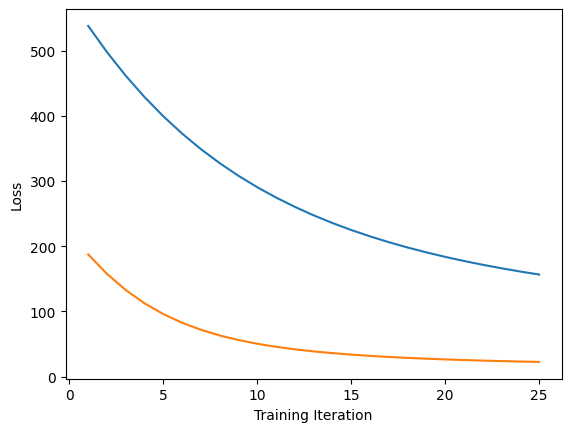

In [130]:
train_time_exact_concrete = train(exact_model_concrete,
                                 exact_likelihood_concrete,
                                 x_train_concrete,
                                 y_train_concrete,
                                 training_iter= 25) # train is defined in utils/functions.ipynb


train_time_exact_concrete_standardized = train(exact_model_concrete_standardized,
                                 exact_likelihood_concrete_standardized,
                                 x_train_concrete_standardized,
                                 y_train_concrete,
                                 training_iter= 25) # train is defined in utils/functions.ipynb

# Evaluate Exact-GP

In [131]:

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_concrete = predict(exact_model_concrete, exact_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_exact_concrete, NLPD_exact_concrete, PICP_exact_concrete, MPIW_exact_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_exact_concrete.mean,
      predictions_exact_concrete.variance)# error_metrics defined in utils/functions.ipynb



# Standardized

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_concrete_standardized = predict(exact_model_concrete_standardized, exact_likelihood_concrete_standardized,
                                     x_test_concrete_standardized) # predict is defined in utils/functions.ipynb
  RMSE_exact_concrete_standardized, NLPD_exact_concrete_standardized, PICP_exact_concrete_standardized, MPIW_exact_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_exact_concrete_standardized.mean,
      predictions_exact_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE Exact-GP: ",RMSE_exact_concrete)
  print("NLPD Exact-GP: ",NLPD_exact_concrete)
  print("PICP Exact-GP: ",PICP_exact_concrete)
  print("MPIW Exact-GP: ",MPIW_exact_concrete)
  print("Time Exact-GP: ", train_time_exact_concrete)



  print("RMSE Exact-GP: ",RMSE_exact_concrete_standardized)
  print("NLPD Exact-GP: ",NLPD_exact_concrete_standardized)
  print("PICP Exact-GP: ",PICP_exact_concrete_standardized)
  print("MPIW Exact-GP: ",MPIW_exact_concrete_standardized)
  print("Time Exact-GP: ", train_time_exact_concrete_standardized)

RMSE Exact-GP:  29.70647
NLPD Exact-GP:  tensor(103.8427)
PICP Exact-GP:  0.02912621359223301
MPIW Exact-GP:  8.114972
Time Exact-GP:  1.5877315998077393
RMSE Exact-GP:  6.564622
NLPD Exact-GP:  tensor(9.9920)
PICP Exact-GP:  0.38349514563106796
MPIW Exact-GP:  6.0073714
Time Exact-GP:  1.1117572784423828


# Display Results

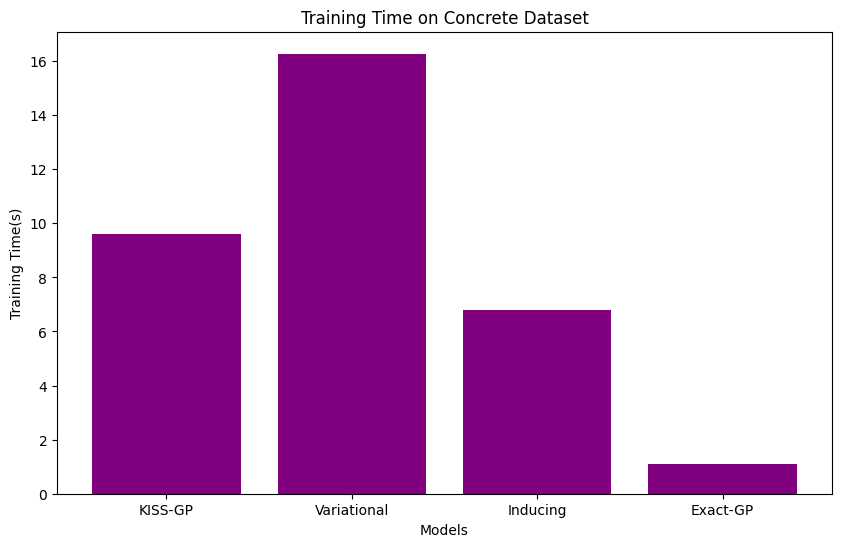

In [132]:
# Training times
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
times_concrete = [train_time_KISSGP_concrete_standardized, train_time_variational_concrete_standardized, train_time_inducing_concrete_standardized, train_time_exact_concrete_standardized]
plot_bar(models, times_concrete, "Training Time on Concrete Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

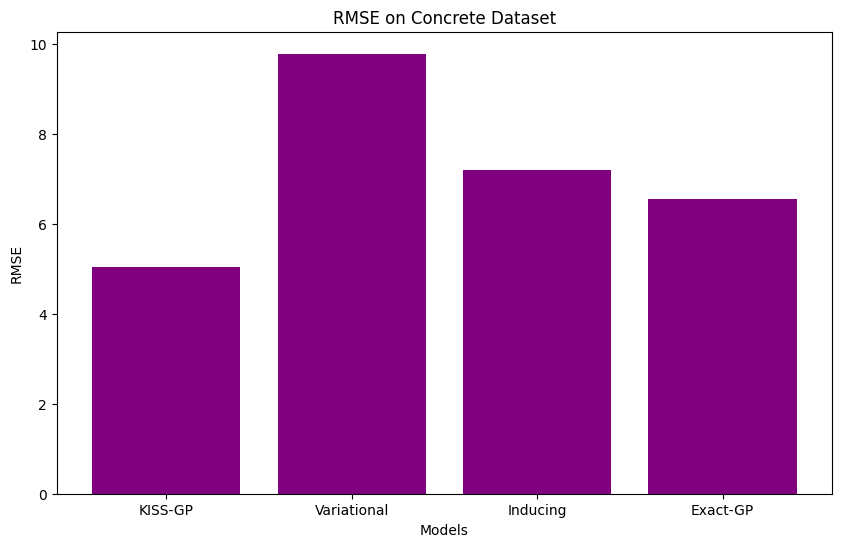

In [133]:
# RMSE
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
RMSE_concrete = [RMSE_KISSGP_concrete_standardized, RMSE_variational_concrete_standardized, RMSE_inducing_concrete_standardized,RMSE_exact_concrete_standardized]
plot_bar(models, RMSE_concrete, "RMSE on Concrete Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

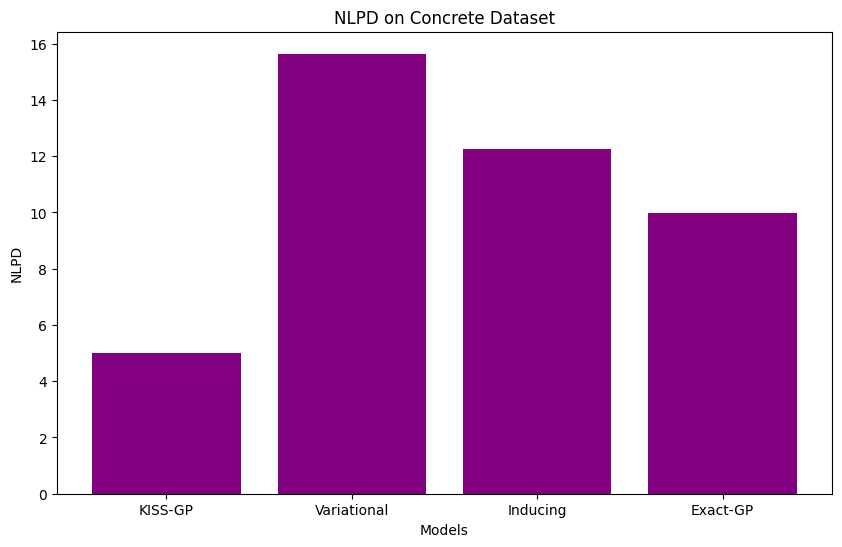

In [134]:
# NLPD
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
NLPD_concrete = [NLPD_KISSGP_concrete_standardized, NLPD_variational_concrete_standardized, NLPD_inducing_concrete_standardized,NLPD_exact_concrete_standardized]
plot_bar(models, NLPD_concrete, "NLPD on Concrete Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

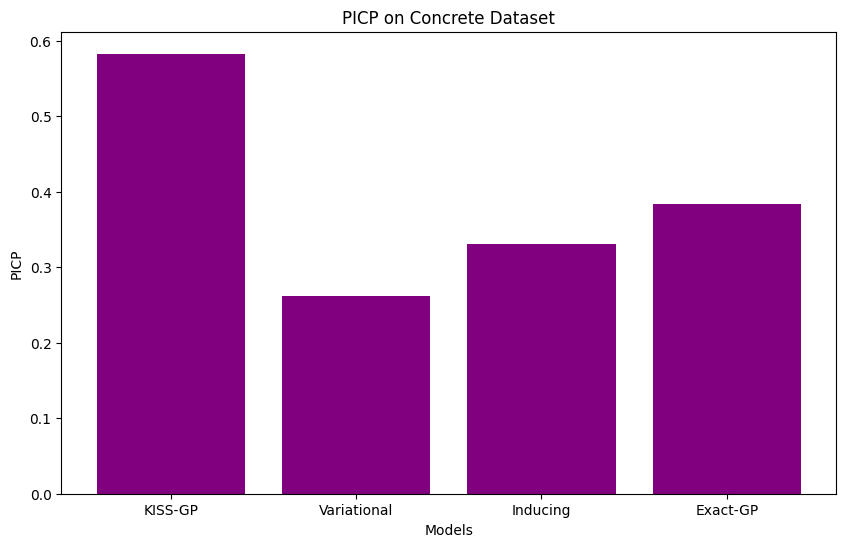

In [135]:
# PICP
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
PICP_concrete = [PICP_KISSGP_concrete_standardized, PICP_variational_concrete_standardized, PICP_inducing_concrete_standardized,PICP_exact_concrete_standardized]
plot_bar(models, PICP_concrete, "PICP on Concrete Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

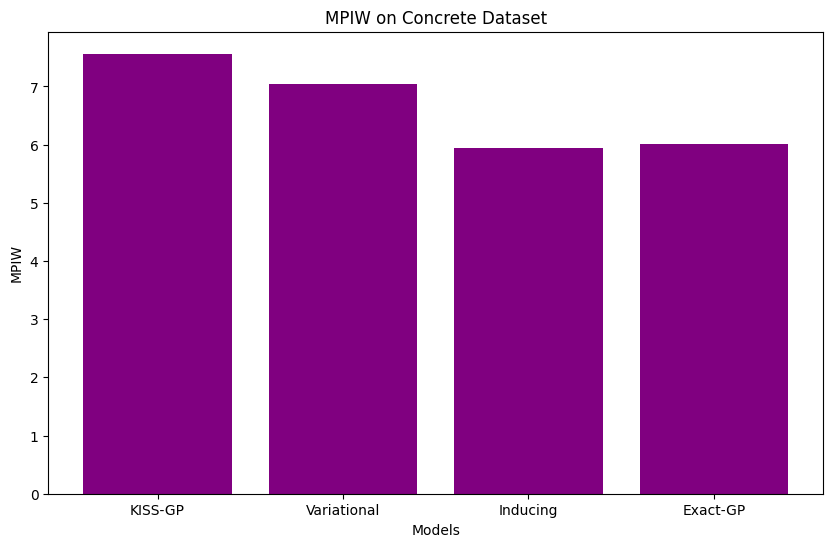

In [136]:
# MPIW
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
MPIW_concrete = [MPIW_KISSGP_concrete_standardized, MPIW_variational_concrete_standardized, MPIW_inducing_concrete_standardized, MPIW_exact_concrete_standardized]
plot_bar(models, MPIW_concrete, "MPIW on Concrete Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

In [137]:
# Create table to summarize the best models
values_best = [
    times_concrete,
    RMSE_concrete,
    NLPD_concrete,
    PICP_concrete,
    MPIW_concrete
]

# Start the tabular environment
latex_table = "\\begin{tabular}{" + "c" * (len(models) + 1) + "}\n"

# Add the model names to the table
latex_table += " & " + " & ".join(models) + " \\\\\n\\hline\n"

# Add the values to the table
for i in range(len(values_best)):
    latex_table += "Array" + str(i+1) + " & " + " & ".join(map(str, values_best[i])) + " \\\\\n"

# End the tabular environment
latex_table += "\\end{tabular}"

print(latex_table)

\begin{tabular}{ccccc}
 & KISS-GP & Variational & Inducing & Exact-GP \\
\hline
Array1 & 9.60771894454956 & 16.271397829055786 & 6.807388067245483 & 1.1117572784423828 \\
Array2 & 5.0361915 & 9.790443505568389 & 7.2114563 & 6.564622 \\
Array3 & tensor(4.9882) & tensor(15.6419, dtype=torch.float64) & tensor(12.2687) & tensor(9.9920) \\
Array4 & 0.5825242718446602 & 0.2621359223300971 & 0.3300970873786408 & 0.38349514563106796 \\
Array5 & 7.561472 & 7.041892141870726 & 5.948218 & 6.0073714 \\
\end{tabular}


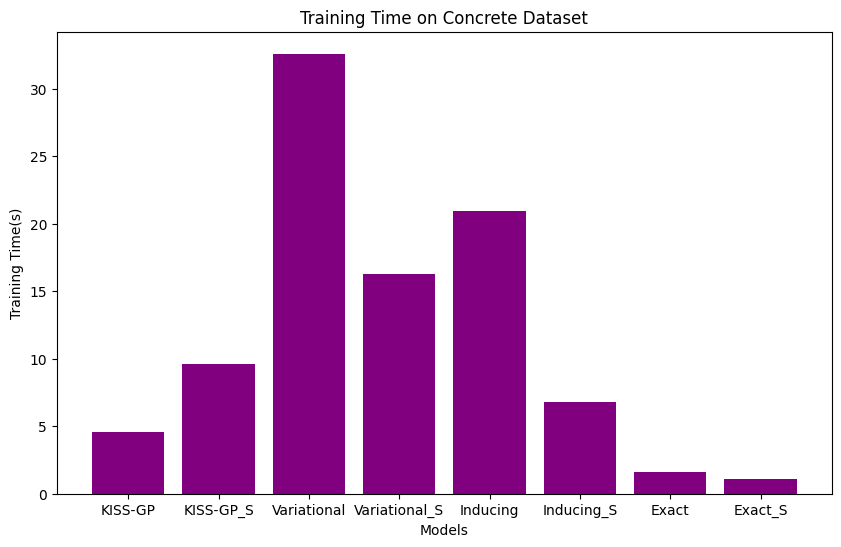

In [138]:
# Standardized or not?
# Training Time
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
time_compare = [train_time_KISSGP_concrete, train_time_KISSGP_concrete_standardized,
                train_time_variational_concrete, train_time_variational_concrete_standardized,
                train_time_inducing_concrete, train_time_inducing_concrete_standardized,
                train_time_exact_concrete, train_time_exact_concrete_standardized]
plot_bar(models_compare, time_compare, "Training Time on Concrete Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

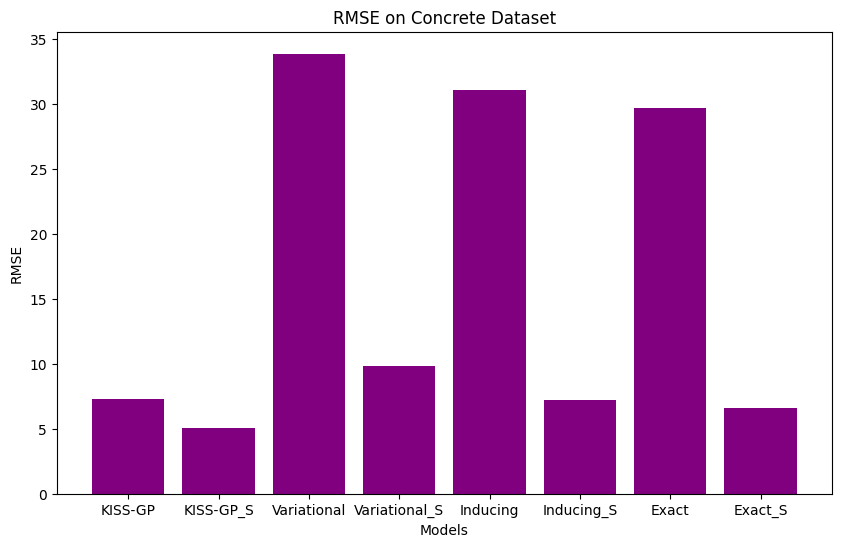

In [139]:
# Standardized or not?
# RMSE
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
RMSE_compare = [RMSE_KISSGP_concrete, RMSE_KISSGP_concrete_standardized,
                RMSE_variational_concrete, RMSE_variational_concrete_standardized,
                RMSE_inducing_concrete, RMSE_inducing_concrete_standardized,
                RMSE_exact_concrete,RMSE_exact_concrete_standardized]
plot_bar(models_compare, RMSE_compare, "RMSE on Concrete Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

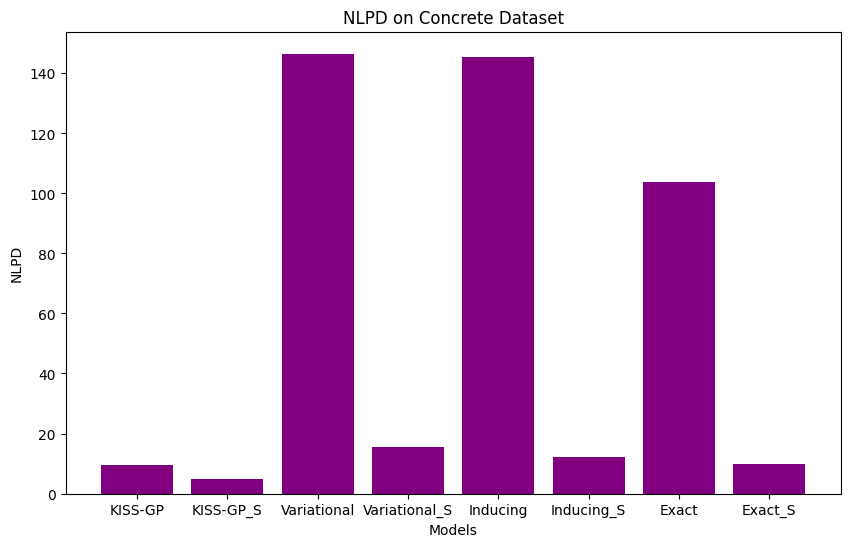

In [140]:
# Standardized or not?
# NLPD
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
NLPD_compare = [NLPD_KISSGP_concrete, NLPD_KISSGP_concrete_standardized,
                NLPD_variational_concrete, NLPD_variational_concrete_standardized,
                NLPD_inducing_concrete, NLPD_inducing_concrete_standardized,
                NLPD_exact_concrete, NLPD_exact_concrete_standardized]
plot_bar(models_compare, NLPD_compare, "NLPD on Concrete Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

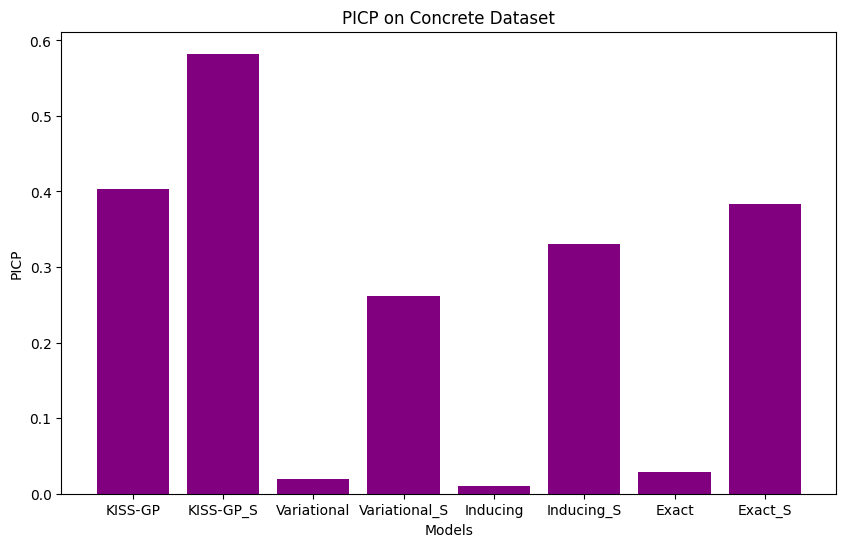

In [141]:
# Standardized or not?
# PICP
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
PICP_compare = [PICP_KISSGP_concrete, PICP_KISSGP_concrete_standardized,
                PICP_variational_concrete, PICP_variational_concrete_standardized,
                PICP_inducing_concrete, PICP_inducing_concrete_standardized,
                PICP_exact_concrete, PICP_exact_concrete_standardized]
plot_bar(models_compare, PICP_compare, "PICP on Concrete Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

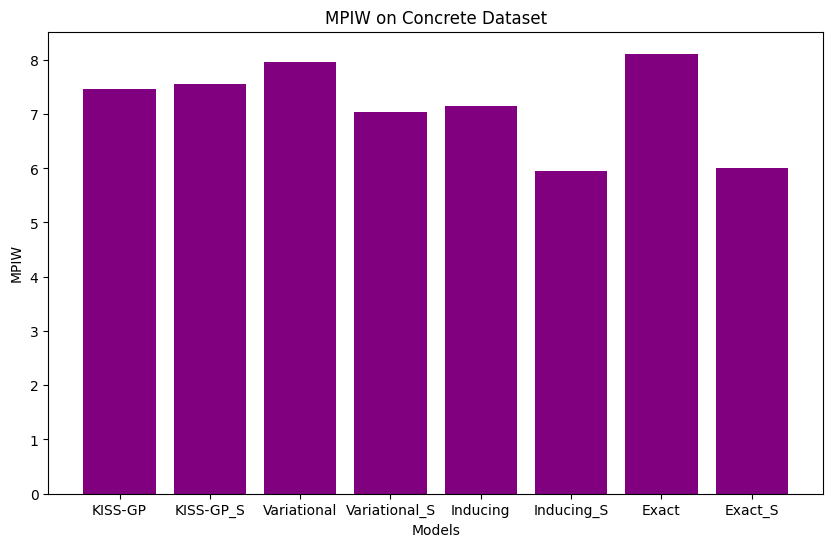

In [142]:
# Standardized or not?
# MPIW
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
MPIW_compare = [MPIW_KISSGP_concrete, MPIW_KISSGP_concrete_standardized,
                MPIW_variational_concrete, MPIW_variational_concrete_standardized,
                MPIW_inducing_concrete, MPIW_inducing_concrete_standardized,
                MPIW_exact_concrete, MPIW_exact_concrete_standardized]
plot_bar(models_compare, MPIW_compare, "MPIW on Concrete Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

In [143]:
# Create table to summarize differences between standardized and not, in Latex

values_compare = [
    time_compare,
    RMSE_compare,
    NLPD_compare,
    PICP_compare,
    MPIW_compare
]

# Start the tabular environment
latex_table = "\\begin{tabular}{" + "c" * (len(models_compare) + 1) + "}\n"

# Add the model names to the table
latex_table += " & " + " & ".join(models_compare) + " \\\\\n\\hline\n"

# Add the values to the table
for i in range(len(values_compare)):
    latex_table += "Array" + str(i+1) + " & " + " & ".join(map(str, values_compare[i])) + " \\\\\n"

# End the tabular environment
latex_table += "\\end{tabular}"

print(latex_table)


\begin{tabular}{ccccccccc}
 & KISS-GP & KISS-GP_S & Variational & Variational_S & Inducing & Inducing_S & Exact & Exact_S \\
\hline
Array1 & 4.5991833209991455 & 9.60771894454956 & 32.60121393203735 & 16.271397829055786 & 20.95111894607544 & 6.807388067245483 & 1.5877315998077393 & 1.1117572784423828 \\
Array2 & 7.298903 & 5.0361915 & 33.88164865546585 & 9.790443505568389 & 31.09144090915119 & 7.2114563 & 29.70647 & 6.564622 \\
Array3 & tensor(9.4190) & tensor(4.9882) & tensor(146.5432, dtype=torch.float64) & tensor(15.6419, dtype=torch.float64) & tensor(145.5584, dtype=torch.float64) & tensor(12.2687) & tensor(103.8427) & tensor(9.9920) \\
Array4 & 0.4029126213592233 & 0.5825242718446602 & 0.019417475728155338 & 0.2621359223300971 & 0.009708737864077669 & 0.3300970873786408 & 0.02912621359223301 & 0.38349514563106796 \\
Array5 & 7.470776 & 7.561472 & 7.95099560612532 & 7.041892141870726 & 7.15313476038923 & 5.948218 & 8.114972 & 6.0073714 \\
\end{tabular}
